In [426]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [427]:
import numpy as np
import copy
import itertools
from scipy import linalg as sLA
from numpy import linalg as LA
import time
from copy import deepcopy
from scipy.stats import unitary_group
import cmath
from matplotlib import pyplot as plt
import scipy
import scipy.special
import random
from IPython.display import Image

import sys
sys.path.append("../scripts")



from Gates import *
from functions import *
from state import *
from Unitary import *

# Классические одномерные случайные блуждания:

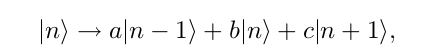

In [428]:
Image('classic_walk.png')

In [3]:


N = 50    
pr = 0.5  
i = 0     

def random_walk(pr, N, i):

    position = i

    for j in range(0, N): 

        coin_flip = list(np.random.choice(2, 1, p=[1-pr, pr]))
        position += 2*coin_flip[0]-1

    return position

print("The walker is located at: x = {var}".format(var = random_walk(pr, N, i)))


The walker is located at: x = 18


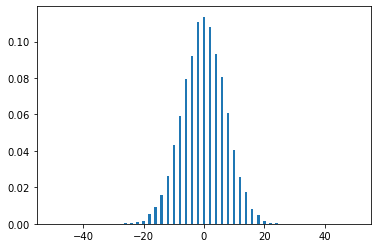

In [4]:
def dist(runs, N):

    positions = range(-1*N, N+1)
    instances = [0 for i in range(-1*N, N+1)]

    for k in range(0, runs):

        result = random_walk(pr, N, i)
        instances[positions.index(result)] += 1

    plt.bar(positions, [n/runs for n in instances])
    plt.show()

dist(10000, N)


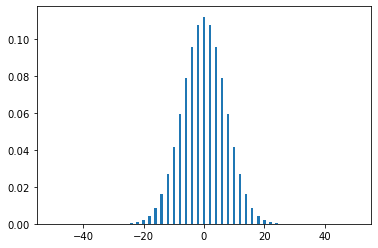

In [5]:
def height_calculate(x, N, pr):

    a = (N + x)/2
    b = (N - x)/2

    if (x%2 == 0):
        var = scipy.special.binom(N, a)*(pr**a)*((1-pr)**b)
    else:
        var = 0
    return var

positions = range(-1*N, N+1)
heights = [height_calculate(x, N, pr) for x in positions]
plt.bar(positions, heights)
plt.show()


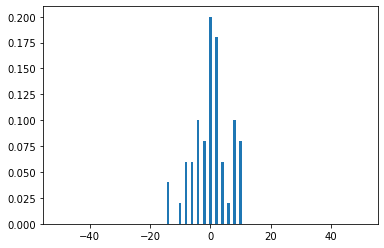

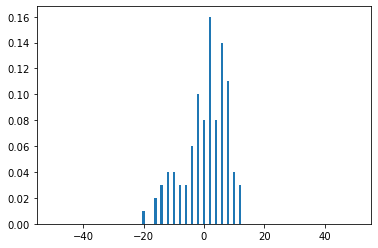

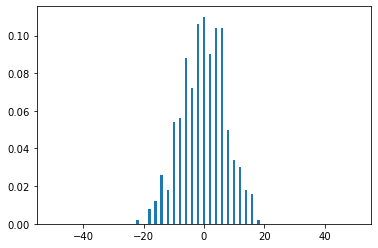

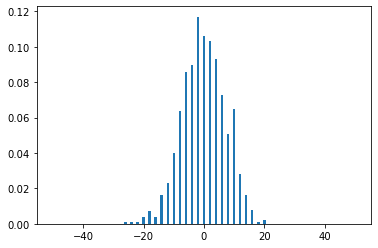

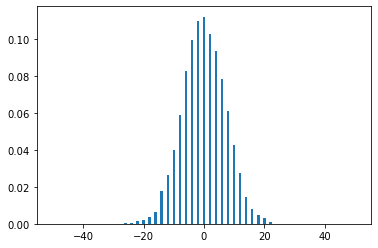

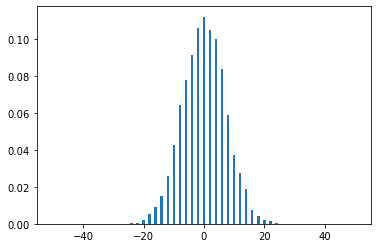

In [6]:
run_range = [50, 100, 500, 1000, 5000, 10000]
for run in run_range:
    dist(run, N)


# Квантовые блуждания

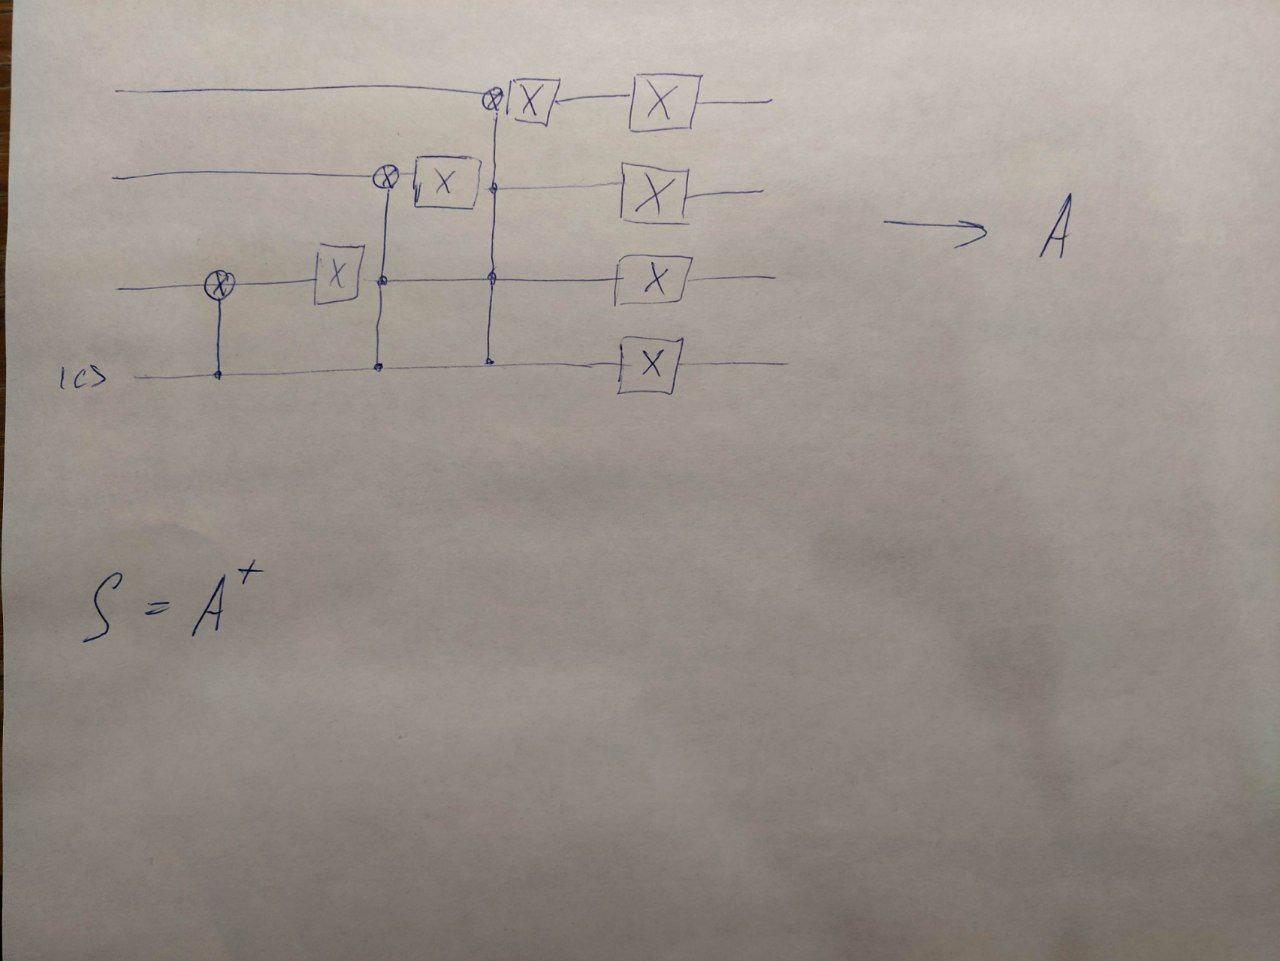

In [403]:
Image('Addition_operator.jpg')

In [365]:
def Subtraction_operator(state, wires):
    N = len(wires)
    
    for wire in wires[:N-1]:
        state.apply_U(X(), [wire])

    
    for wire in reversed(range(1,N)):
        local_wires = N-1 - np.array(list(range(wire+1)))
        state.apply_U(X(), [N-1 - wire])
        state.apply_long_Toffoli(axis = local_wires)
        
def Addition_operator(state, wires):
    N = len(wires)
    
    for wire in range(1,N):
        local_wires = N-1 - np.array(list(range(wire+1)))
        state.apply_long_Toffoli(axis = local_wires)
        state.apply_U(X(), [N-1 - wire])
        
    
    for wire in wires[:N-1]:
        state.apply_U(X(), [wire])
        

# Алгоритм квантовых блужданий

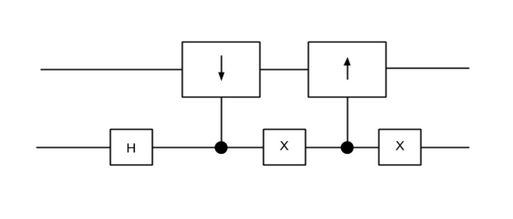

In [408]:
Image('step.png')

In [454]:
def step(state, wires):
    state.apply_U(H(), [wires[-1]])
#     state.apply_U(S(), [wires[-1]])
    Subtraction_operator(state, wires)
    state.apply_U(X(), [wires[-1]])
    Addition_operator(state, wires)
    state.apply_U(X(), [wires[-1]])
    
def Quantum_walk_linear(state, steps):
    
    
    state0 = copy.deepcopy(state)
    state0.split_system(int(state.N)-1,1)
    coef_hist = [state0.get_A_coefs()]
#     coef_hist = [state0.get_coefs()]
    
    init_time = time.time()
    for s in range(steps):
        step(state0, wires = list(range(state.N)))
        state0.split_system(int(state.N)-1, 1)
        coef_hist.append(state0.get_A_coefs())
#         coef_hist.append(state0.get_coefs())
        
        print('step: ', s)
        print('time: ', time.time() - init_time)
        
    return state0, coef_hist

def projection(a,b):
    a = np.array(a)
    b = np.array(b)
    
    p = np.dot(a.conj(),b)
    
    return p

def get_statistics(coefs):

    projection_list = []
    num_list = []
    vec_list = []
    for i in range(0, len(coefs)):
        
        
        num_list.append(i)
        vec = np.zeros(len(coefs))
        vec[i] = 1
        vec_list.append(vec)
        projection_list.append(projection(coefs,vec)**2)
        
    res = np.array([num_list, projection_list])
        
    return res



In [500]:
random.seed(2)

n = 2
state0 = Qpsi(1)
state1 = Qpsi(n)
state = Qpsi(n+1)

state0.build_zero_state()
state0.apply_U(X(), [0])
state1.build_zero_state()
state1.apply_U(X(), [0])

state.set_coefs(np.kron(state1.get_coefs(), state0.get_coefs()))

print(state0.get_coefs(),state1.get_coefs(), list(state.get_coefs()))

[0.+0.j 1.+0.j] [0.+0.j 0.+0.j 1.+0.j 0.+0.j] [0j, 0j, 0j, 0j, 0j, (1+0j), 0j, 0j]


In [503]:
state.split_system(n,1)
coefs_A = state.get_A_coefs()
print(state.get_A_coefs(), state.get_B_coefs(), state.get_coefs())
Subtraction_operator(state, wires = [0,1,2])
# Addition_operator(state, wires = [0,1,2])
state.split_system(n,1)
print(state.get_A_coefs(), state.get_B_coefs(), state.get_coefs())

print()
print('_________')
print()

print(np.around(coefs_A.astype('float')))
print(np.around(state.get_A_coefs().astype('float')))

[0.+0.j 0.+0.j 1.+0.j 0.+0.j] [0.+0.j 1.+0.j] [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
[ 0.00000000e+00+0.00000000e+00j  1.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j -1.02111527e-32+1.57009246e-16j] [0.+0.j 1.+0.j] [0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
 0.00000000e+00+0.00000000e+00j 1.00000000e+00-1.66533454e-16j
 0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
 0.00000000e+00+0.00000000e+00j 1.23259516e-32+1.57009246e-16j]

_________

[0. 0. 1. 0.]
[ 0.  1.  0. -0.]


/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


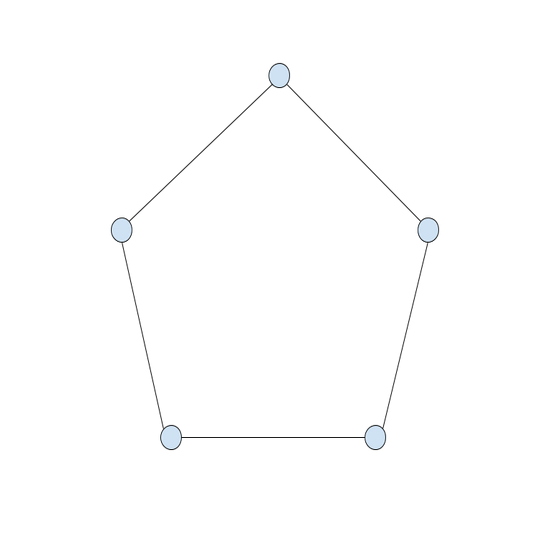

In [490]:
Image('graph.png')

In [394]:
random.seed(2)

n = 6
state0 = Qpsi(1)
state1 = Qpsi(n)
state = Qpsi(n+1)

state0.build_zero_state()
state0.apply_U(X(), [0])
# state1.build_random_state()
state1.build_zero_state()
state1.apply_U(X(), [0])

state.set_coefs(np.kron(state1.get_coefs(), state0.get_coefs()))

print(state0.get_coefs(),state1.get_coefs(), list(state.get_coefs()))




[0.+0.j 1.+0.j] [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j] [0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, (1+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j]


In [395]:
# coefs = state.get_coefs()
# print(coefs)
# Subtraction_operator(state, wires = [0,1,2])
# # Addition_operator(state, wires = [0,1,2])
# print(coefs - state.get_coefs())


In [396]:
# state.split_system(n,1)
# print(state.get_A_coefs(), state.get_B_coefs(), state.get_coefs())

In [397]:
steps = 30
res_state, coef_hist = Quantum_walk_linear(state, steps)

step:  0
time:  33.45303177833557
step:  1
time:  66.7281699180603
step:  2
time:  100.38107299804688
step:  3
time:  133.7676157951355
step:  4
time:  167.64125967025757
step:  5
time:  201.0486409664154
step:  6
time:  234.73748183250427
step:  7
time:  267.9998073577881
step:  8
time:  301.2697744369507
step:  9
time:  334.92441296577454
step:  10
time:  368.31863284111023
step:  11
time:  401.5517807006836
step:  12
time:  434.8678255081177
step:  13
time:  468.6981797218323
step:  14
time:  503.4688618183136
step:  15
time:  538.6933145523071
step:  16
time:  577.2721767425537
step:  17
time:  610.5713984966278
step:  18
time:  644.6024737358093
step:  19
time:  681.5576620101929
step:  20
time:  716.9079904556274
step:  21
time:  751.3183016777039
step:  22
time:  788.4332582950592
step:  23
time:  824.8818323612213
step:  24
time:  860.1459121704102
step:  25
time:  895.1453664302826
step:  26
time:  929.8149979114532
step:  27
time:  963.8176693916321
step:  28
time:  997.35670

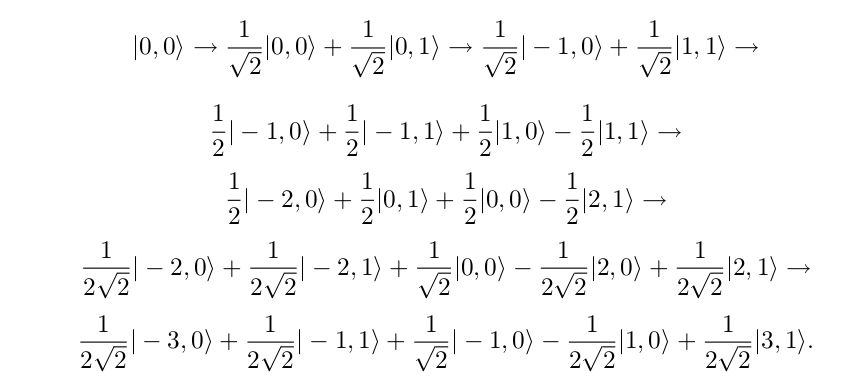

In [430]:
Image('3_step.png')

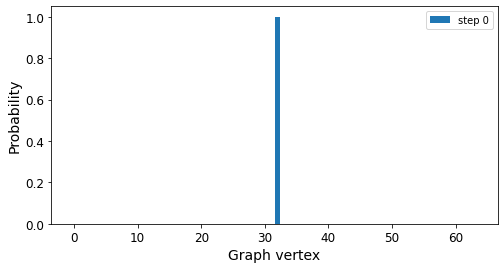

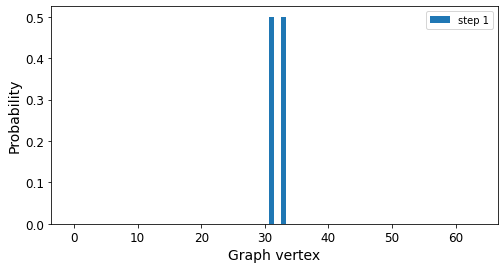

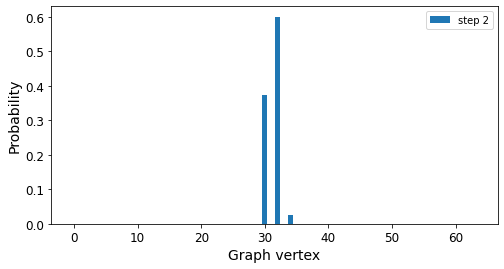

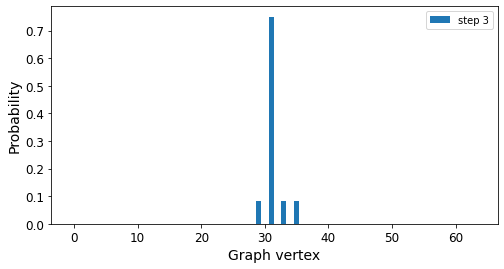

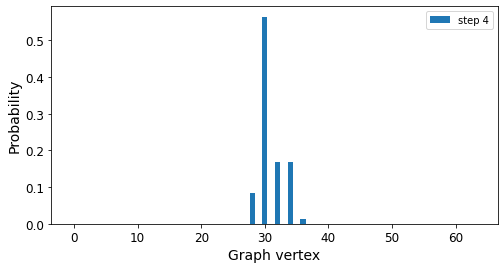

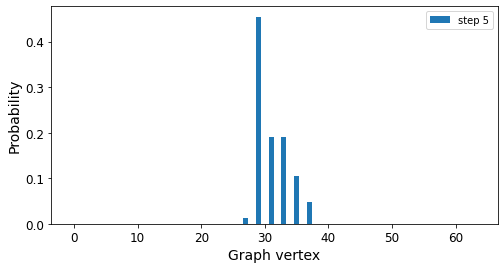

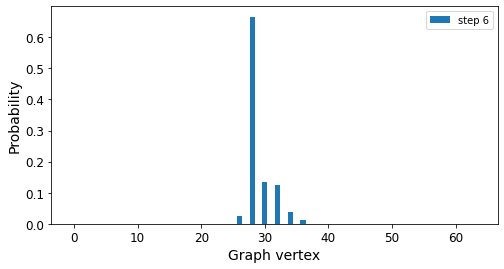

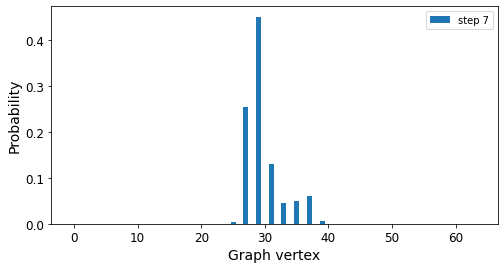

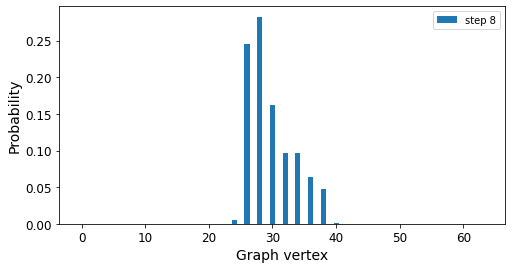

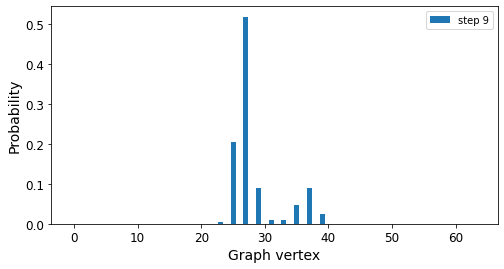

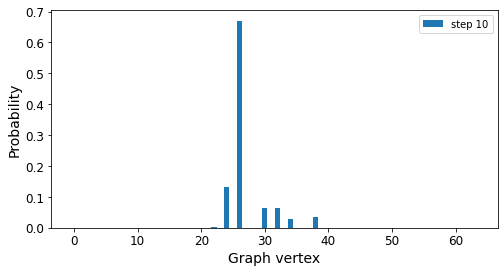

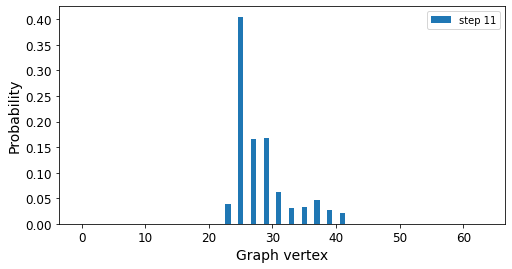

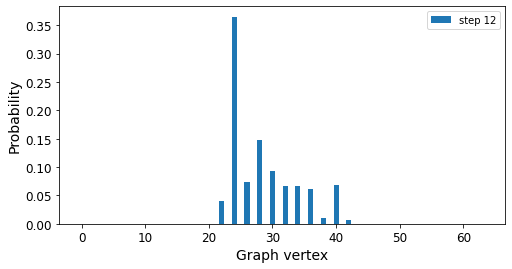

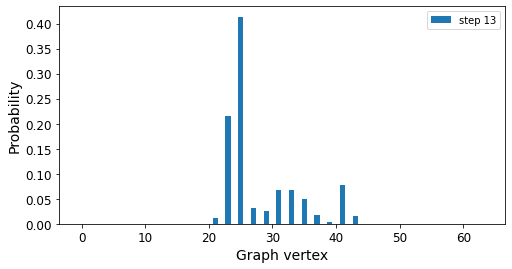

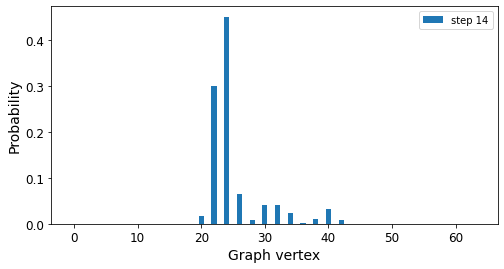

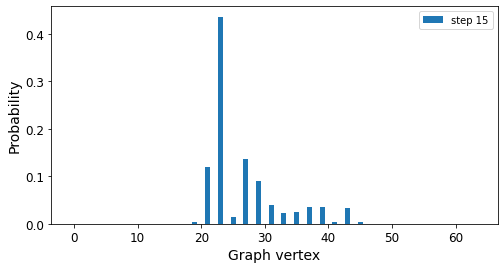

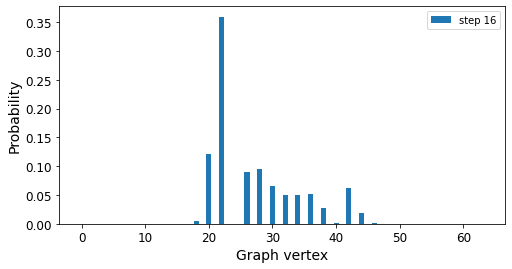

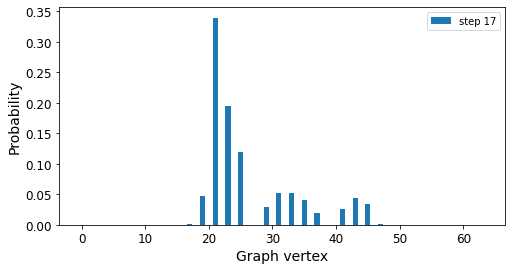

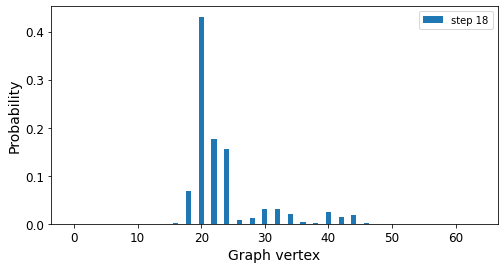

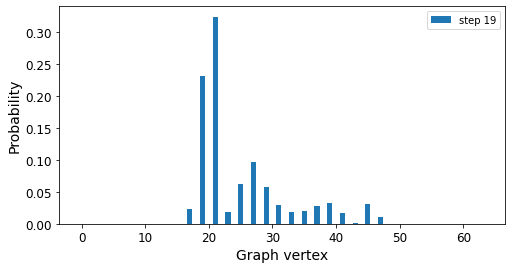

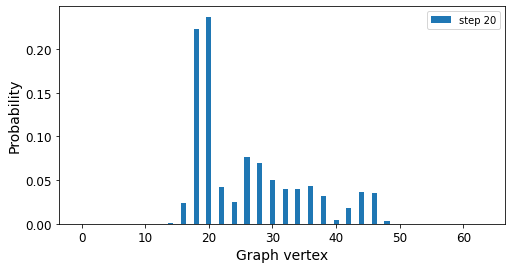

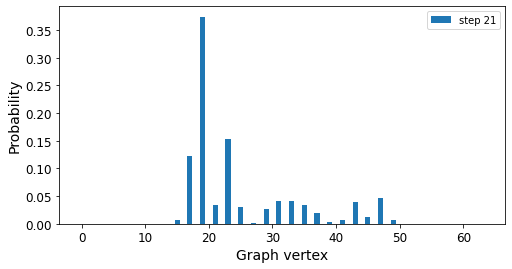

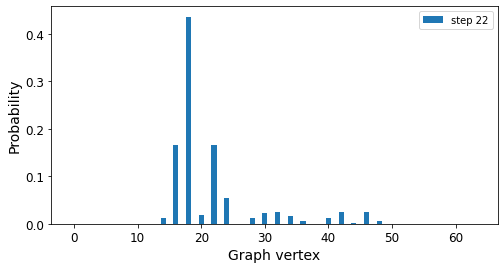

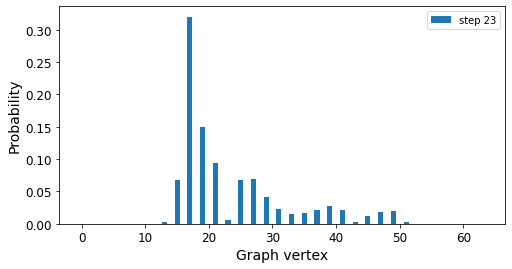

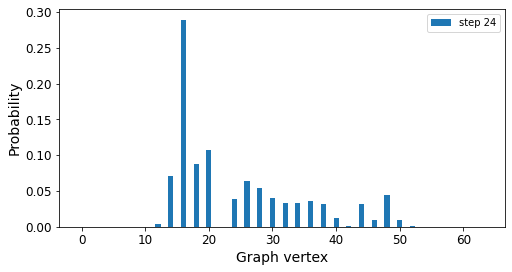

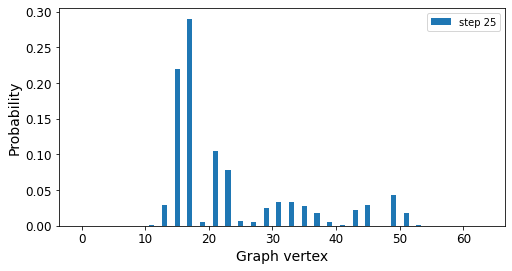

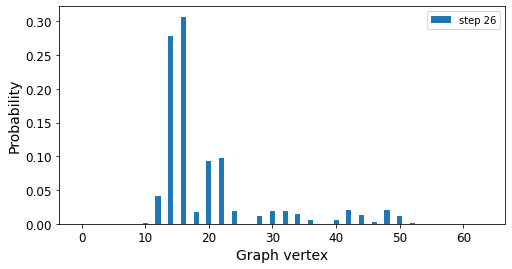

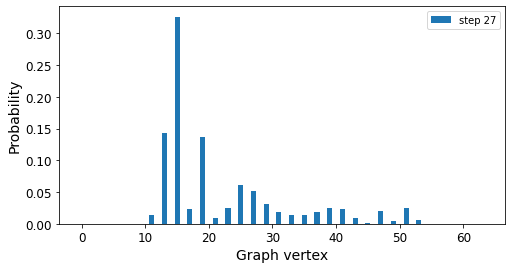

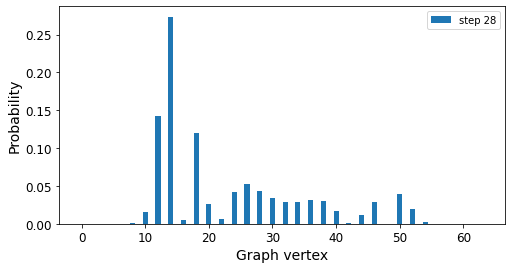

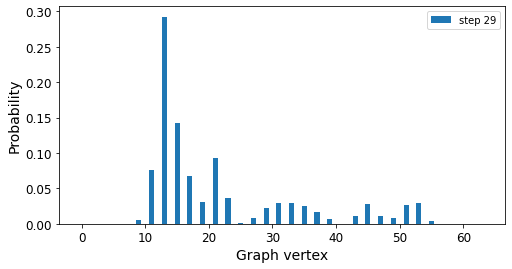

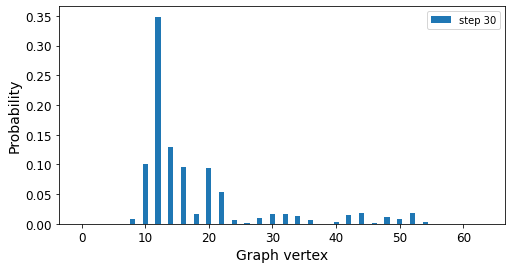

In [398]:
i=0
for coefs in coef_hist:
    plt.figure(figsize = (8,4))
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.ylabel(r'Probability', fontsize = 14)
    plt.xlabel(r'Graph vertex', fontsize = 14)
#     res = get_statistics(coefs)
    plt.bar(list(range(len(coefs))), coefs*coefs.conj()/(np.sum(abs(coefs*coefs.conj()))), label = 'step ' + str(i) )
#     plt.bar(res[0].astype('float'), res[1].astype('float'), label = 'step ' + str(i) )
    plt.legend()
    plt.show()
    i+=1

In [469]:
random.seed(2)

n = 5
state0 = Qpsi(1)
state1 = Qpsi(n)
state = Qpsi(n+1)

state0.build_zero_state()
# state0.apply_U(X(), [0])
# state0.apply_U(H(), [0])
# state0.apply_U(S(), [0])

state1.build_zero_state()
state1.apply_U(X(), [0])

state.set_coefs(np.kron(state1.get_coefs(), state0.get_coefs()))

print(state0.get_coefs(),state1.get_coefs(), state.get_coefs())

[1.+0.j 0.+0.j] [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j] [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [470]:
steps = 30
res2_state, coef1_hist = Quantum_walk_linear(state, steps)

state.apply_U(X(), [n])
steps = 30
res2_state, coef2_hist = Quantum_walk_linear(state, steps)

step:  0
time:  6.487952709197998
step:  1
time:  12.923302173614502
step:  2
time:  19.40601396560669
step:  3
time:  26.379354238510132
step:  4
time:  32.876349449157715
step:  5
time:  39.84724974632263
step:  6
time:  47.059550762176514
step:  7
time:  54.36170816421509
step:  8
time:  61.20441222190857
step:  9
time:  67.96538877487183
step:  10
time:  74.4739305973053
step:  11
time:  80.86283612251282
step:  12
time:  87.73277497291565
step:  13
time:  94.9515061378479
step:  14
time:  101.53292679786682
step:  15
time:  108.00060629844666
step:  16
time:  114.46559572219849
step:  17
time:  120.94629645347595
step:  18
time:  127.40171551704407
step:  19
time:  134.58274698257446
step:  20
time:  141.56036472320557
step:  21
time:  148.60231566429138
step:  22
time:  155.2504267692566
step:  23
time:  161.91350603103638
step:  24
time:  168.8846538066864
step:  25
time:  175.7253017425537
step:  26
time:  183.83214712142944
step:  27
time:  191.15070033073425
step:  28
time:  

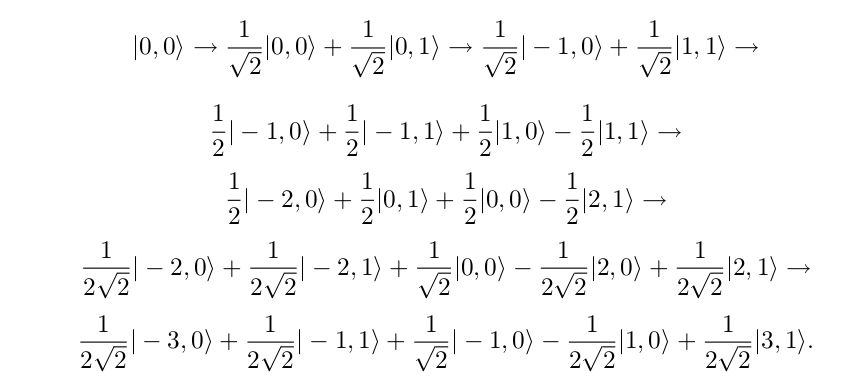

In [472]:
Image('3_step.png')

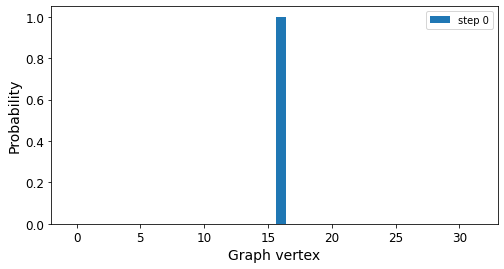

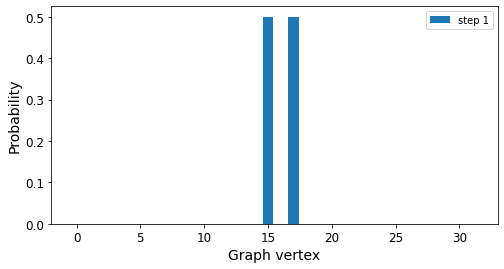

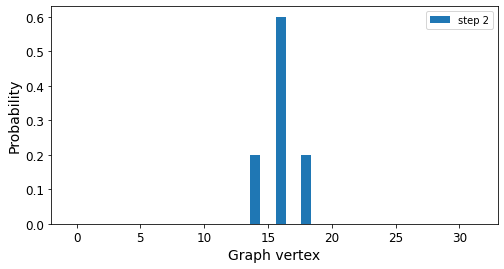

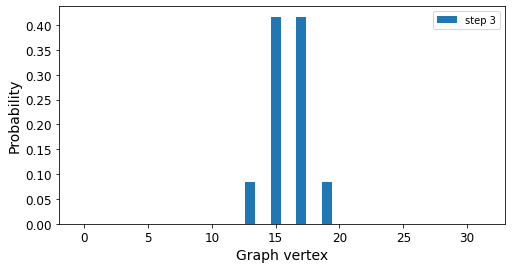

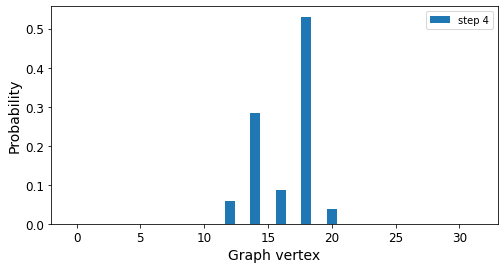

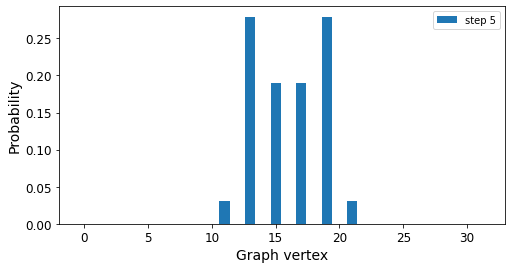

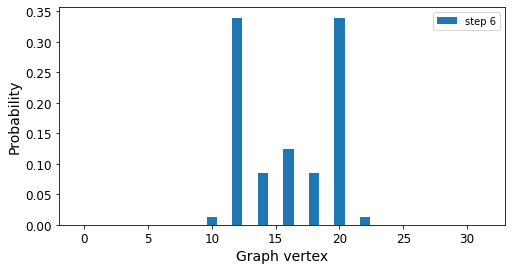

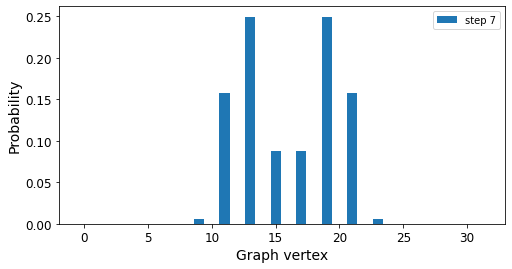

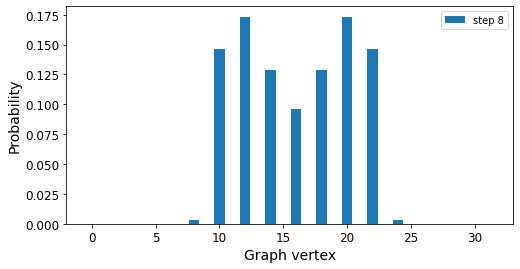

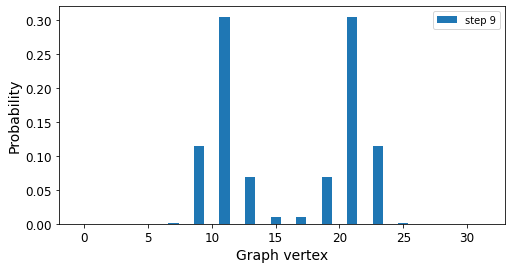

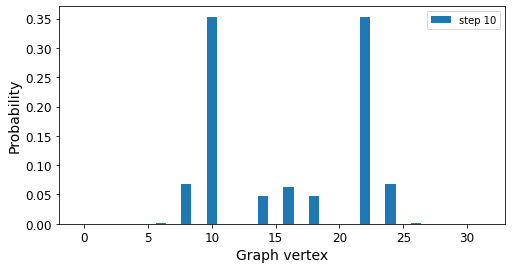

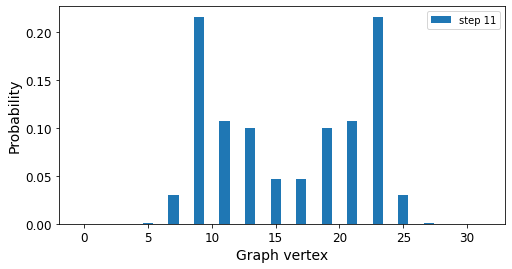

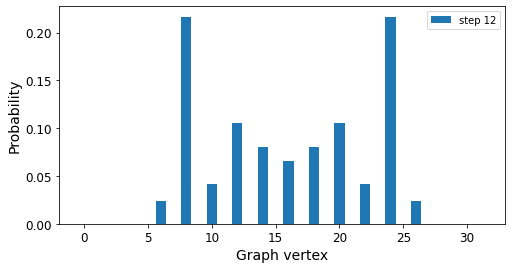

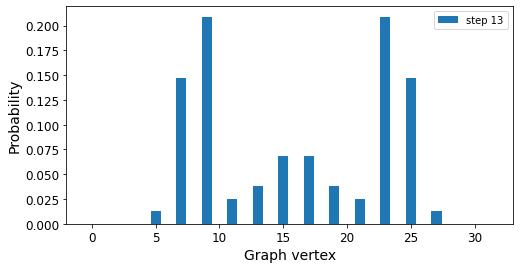

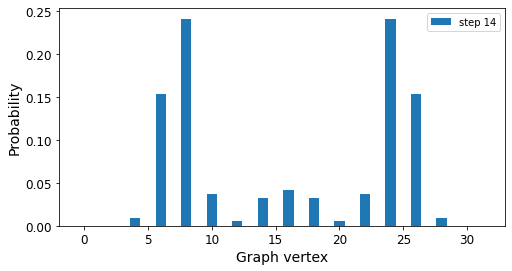

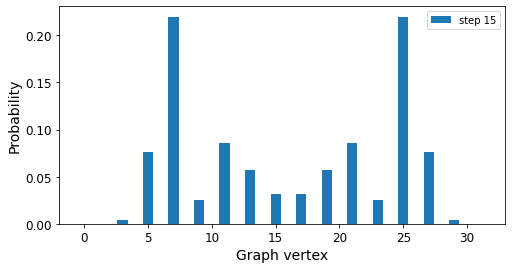

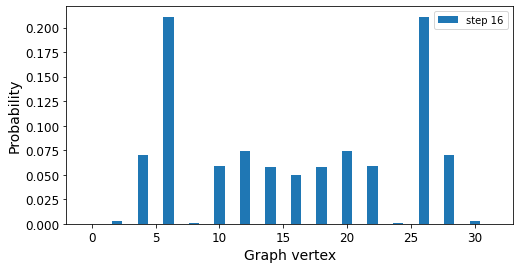

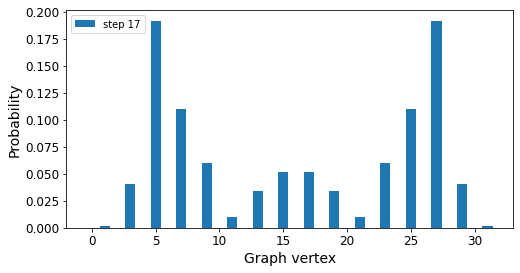

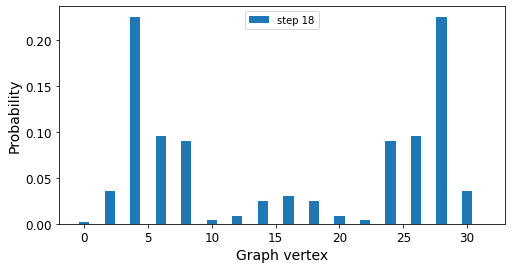

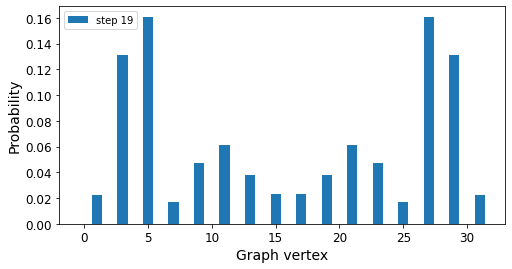

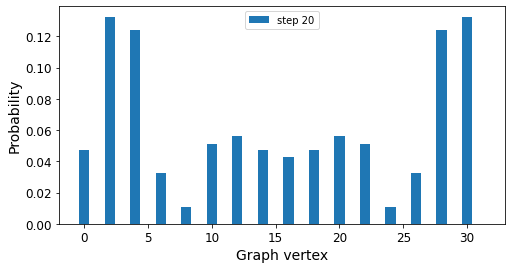

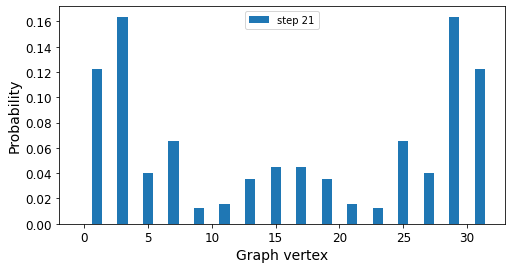

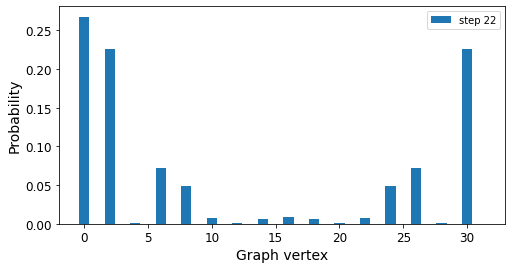

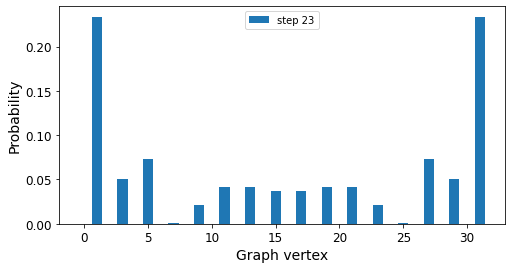

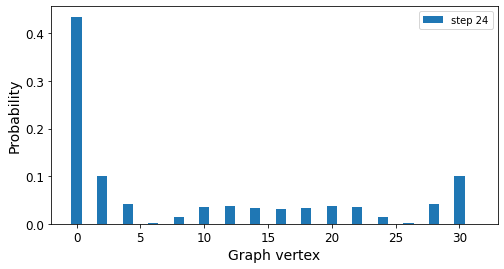

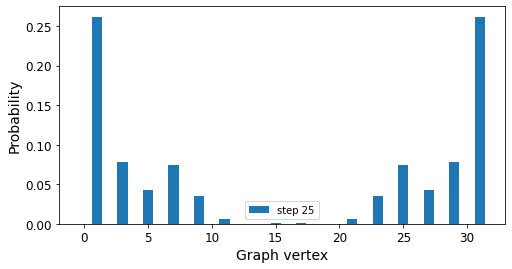

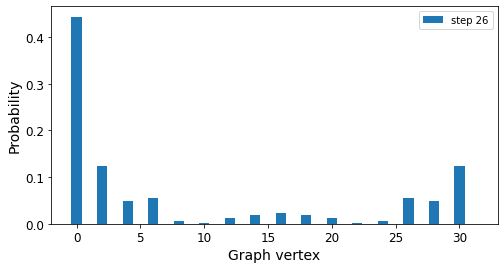

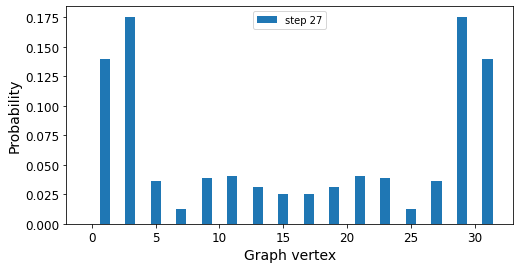

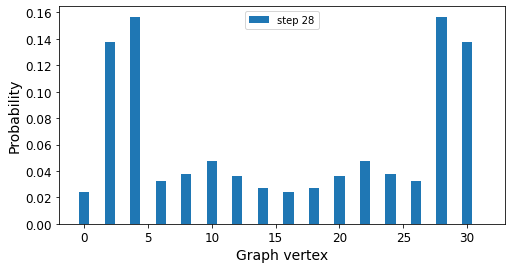

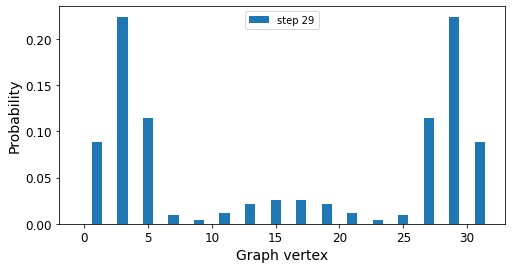

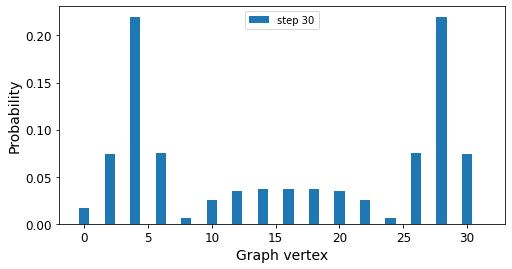

In [471]:
i=0
for coefs1, coefs2 in zip(coef1_hist, coef2_hist):
    plt.figure(figsize = (8,4))
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.ylabel(r'Probability', fontsize = 14)
    plt.xlabel(r'Graph vertex', fontsize = 14)
    c = (coefs1*coefs1.conj()/(np.sum(abs(coefs1*coefs1.conj()))) + (coefs2*coefs2.conj()/(np.sum(abs(coefs2*coefs2.conj())))))/2
    plt.bar(list(range(len(coefs1))),c, label = 'step ' + str(i) )
    plt.legend()
    plt.show()
    i+=1

# Проверка работы Тоффоли

In [416]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../scripts")



from Gates import *
from functions import *
from state import *
from Unitary import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [248]:
state = Qpsi(5)
state.build_zero_state()
# state.apply_U(X(), [0])
state.apply_U(X(), [1])
state.apply_U(X(), [2])
# state.apply_U(X(), [3])
# state.apply_U(X(), [4])
print(state.get_coefs())

print(state.get_coefs() - apply_long_Toffoli(state.get_coefs(), wires = [0,1,2,3]))


[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j]
[0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 6.66133815e-16+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j]


In [275]:
state = Qpsi(3)
state.build_zero_state()
print(state.get_coefs())
# state.apply_U(X(), [0])
state.apply_U(X(), [1])
state.apply_U(X(), [2])
print(state.get_coefs(), apply_long_Toffoli(state.get_coefs(), wires = [1,2,0]))


[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j] [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j -3.92523115e-17+1.17756934e-16j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  1.00000000e+00-2.22044605e-16j]


In [283]:
state = Qpsi(2)
state.build_zero_state()
print(state.get_coefs())
state.apply_U(X(), [0])
state.apply_U(X(), [1])

print(state.get_coefs(), apply_long_Toffoli(state.get_coefs(), wires = [1,0]))


[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0.+0.j 0.+0.j 0.+0.j 1.+0.j] [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
